In [1]:
import numpy as np
import pandas as pd
import open3d
import os
import tqdm
import matplotlib.pyplot as plt
import utils.helpers as helpers
import utils.fread as fread
import utils.registration as registration
import scipy

from utils.depth_camera import DepthCamera

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [108]:
data_dir = "data/exp_7"
trial = "trial_1"
subject = "subject-1"
sequence = 4

In [109]:
motion_dir = os.path.join(data_dir, trial, subject, f"{sequence:02d}", "motion")

In [110]:
accel_df = pd.read_csv(os.path.join(motion_dir, "accelerometer"))
gyro_df = pd.read_csv(os.path.join(motion_dir, "gyroscope"))

In [111]:
accel_df.drop_duplicates("timestamp", inplace=True)
gyro_df.drop_duplicates("timestamp", inplace=True)

In [112]:
imu_df = pd.merge(accel_df, gyro_df, on="timestamp", suffixes=("a", "g"))

In [113]:
alpha = 0.8
gravity = [0, 0, 0]

for i in range(imu_df.shape[0]):
    for j in range(3):
        gravity[j] = alpha * gravity[j] + (1 - alpha) * imu_df.iloc[i, 1 + j]
        imu_df.iloc[i, 1 + j] = imu_df.iloc[i, 1 + j] - gravity[j]

In [114]:
imu_df = imu_df.iloc[400:]

imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])

imu_df = imu_df.iloc[1:]

imu_df.reset_index(drop=True, inplace=True)

In [115]:
imu_df.loc[:, "dx"] = np.zeros(len(imu_df))
imu_df.loc[:, "dy"] = np.zeros(len(imu_df))
imu_df.loc[:, "dz"] = np.zeros(len(imu_df))

In [116]:
imu_df.loc[:, "rx"] = np.zeros(len(imu_df))
imu_df.loc[:, "ry"] = np.zeros(len(imu_df))
imu_df.loc[:, "rz"] = np.zeros(len(imu_df))

In [117]:
# displacement = [0, 0, 0]
velocity = [0, 0, 0]
angle = [0, 0, 0]

for i in range(len(imu_df)):
    imu = imu_df.iloc[i].values
    dt = imu[7]
    for j, axis in enumerate(["x", "y", "z"]):
        velocity[j] = velocity[j] + imu[j + 1] * dt
        # Update the displacement
        # displacement[j] = displacement[j] + (velocity[j] * dt) + (0.5 * acceleration[j + 1] * dt * dt)
        angle[j] += imu[j + 4] * dt

        imu_df.iloc[i, 8 + j] = (velocity[j] * dt) + (0.5 * imu[j + 1] * dt * dt)
        imu_df.iloc[i, 11 + j] = angle[j]

In [118]:
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

In [119]:
for i in range(1, len(imu_df)):
    c = imu_df.iloc[i].values
    p = imu_df.iloc[i - 1].values

    R = helpers.rotate_transformation_matrix(np.identity(4), p[11], p[12], p[13])

    d = np.dot(R, np.array([[c[8], c[9], c[10], 1]]).T)

    imu_df.iloc[i, 14] = p[14] + d[0]
    imu_df.iloc[i, 15] = p[15] + d[1]
    imu_df.iloc[i, 16] = p[16] + d[2]

In [120]:
imu_df

,timestamp,xa,ya,za,xg,yg,zg,dt,dx,dy,dz,rx,ry,rz,x,y,z
0,1.670208e+12,0.001742,0.010091,-0.088066,-0.010483,-0.020946,0.003490,0.003,2.351183e-08,1.362346e-07,-0.000001,-0.000031,-0.000063,0.000010,0.000000e+00,0.000000e+00,0.000000
1,1.670208e+12,0.041825,-0.006525,-0.108907,-0.010483,-0.020946,0.003490,0.002,2.613973e-07,2.139920e-08,-0.000001,-0.000052,-0.000105,0.000017,2.613986e-07,2.139860e-08,-0.000001
2,1.670208e+12,0.017481,0.002292,-0.079603,-0.010483,-0.017455,0.006980,0.003,5.026216e-07,8.261509e-08,-0.000003,-0.000084,-0.000157,0.000038,7.640248e-07,1.040115e-07,-0.000004
3,1.670208e+12,0.014060,0.009725,-0.063533,-0.010483,-0.017455,0.006980,0.002,3.669994e-07,1.065533e-07,-0.000002,-0.000105,-0.000192,0.000052,1.131029e-06,2.105625e-07,-0.000006
4,1.670208e+12,0.035060,0.008208,-0.050052,-0.006993,-0.013964,0.008726,0.003,9.816257e-07,2.414664e-07,-0.000003,-0.000126,-0.000234,0.000079,2.112665e-06,4.520239e-07,-0.000009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16206,1.670208e+12,0.180717,0.135672,-0.469312,-0.328133,-1.378812,-0.411899,0.002,1.638897e-05,-2.091832e-05,-0.000125,-0.057708,-1.187120,-0.420100,3.777692e-01,-6.258301e-01,-0.951049
16207,1.670208e+12,0.186550,0.181125,-0.443810,-0.328133,-1.378812,-0.411899,0.003,2.655973e-05,-2.933931e-05,-0.000192,-0.058692,-1.191257,-0.421336,3.777995e-01,-6.258598e-01,-0.951241
16208,1.670208e+12,0.150240,0.137574,-0.402531,-0.301953,-1.378812,-0.397936,0.002,1.804828e-05,-1.927747e-05,-0.000129,-0.059296,-1.194014,-0.422132,3.778201e-01,-6.258794e-01,-0.951370
16209,1.670208e+12,0.177487,0.143379,-0.382730,-0.301953,-1.378812,-0.397936,0.003,2.901777e-05,-2.739331e-05,-0.000198,-0.060202,-1.198151,-0.423326,3.778531e-01,-6.259072e-01,-0.951567


In [121]:
xyz = imu_df.loc[:, ["x", "y", "z"]].values

pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(xyz)

open3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [58]:
camera = DepthCamera("lidar", "data/exp_7/metadata/device-0-aligned.json")

In [59]:
sequence_dir = os.path.join(data_dir, trial, subject, f"{sequence:02d}", "frames")
sequence_ts = fread.get_timstamps_from_images(sequence_dir, ext=".depth.png")

In [60]:
start_t = sequence_ts[0]
end_t = sequence_ts[-1]

In [7]:
# accel_t = accel_df[(accel_df.timestamp >= start_t) & (accel_df.timestamp <= end_t)]
accel_t = accel_df.iloc[400:].copy()
# remove redundant data
accel_t = accel_t.drop_duplicates("timestamp")
# calculating time difference
accel_t.loc[:, "dt"] = np.concatenate([[0], (accel_t.timestamp.values[1:] - accel_t.timestamp.values[:-1]) / 1000])
# accel_t.loc[:, "dt"] = (accel_t.timestamp.values - accel_t.timestamp.values[0]) / 1000
# remove first row
accel_t = accel_t.iloc[1:]

accel_t.reset_index(drop=True, inplace=True)

In [ ]:
gyro_t = gyro_df.iloc[400:].copy()
# remove redundant data
gyro_t = gyro_t.drop_duplicates("timestamp")
# calculating time difference
# gyro_t.loc[:, "dt"] = np.concatenate([[0], (gyro_t.timestamp.values[1:] - gyro_t.timestamp.values[:-1]) / 1000])
gyro_t.loc[:, "dt"] = (gyro_t.timestamp.values - gyro_t.timestamp.values[0]) / 1000
# remove first row
gyro_t = gyro_t.iloc[1:]

In [9]:
accel_t.loc[:, "Ix"] = np.zeros(len(accel_t))
accel_t.loc[:, "Iy"] = np.zeros(len(accel_t))
accel_t.loc[:, "Iz"] = np.zeros(len(accel_t))

accel_t.loc[:, "I2x"] = np.zeros(len(accel_t))
accel_t.loc[:, "I2y"] = np.zeros(len(accel_t))
accel_t.loc[:, "I2z"] = np.zeros(len(accel_t))

In [10]:
displacement = [0, 0, 0]
velocity = [0, 0, 0]

for i in range(len(accel_t)):
    imu = accel_t.iloc[i].values
    for j, axis in enumerate(["x", "y", "z"]):
        velocity[j] = velocity[j] + imu[j + 1] * imu[4] # 4 = dt
        # Update the displacement
        displacement[j] = displacement[j] + (velocity[j] * imu[4]) + (0.5 * imu[j + 1] * imu[4] * imu[4])

        accel_t.iloc[i, 5 + j] = velocity[j]
        accel_t.iloc[i, 8 + j] = displacement[j]

In [12]:
# accel_t.loc[:, "Ix"] = scipy.integrate.cumtrapz(accel_t.x.values, accel_t.dt.values, initial=0)
# accel_t.loc[:, "Iy"] = scipy.integrate.cumtrapz(accel_t.y.values, accel_t.dt.values, initial=0)
# accel_t.loc[:, "Iz"] = scipy.integrate.cumtrapz(accel_t.z.values, accel_t.dt.values, initial=0)
#
# accel_t.loc[:, "I2x"] = scipy.integrate.cumtrapz(accel_t.Ix.values, accel_t.dt.values, initial=0)
# accel_t.loc[:, "I2y"] = scipy.integrate.cumtrapz(accel_t.Iy.values, accel_t.dt.values, initial=0)
# accel_t.loc[:, "I2z"] = scipy.integrate.cumtrapz(accel_t.Iz.values, accel_t.dt.values, initial=0)

<AxesSubplot:xlabel='timestamp'>

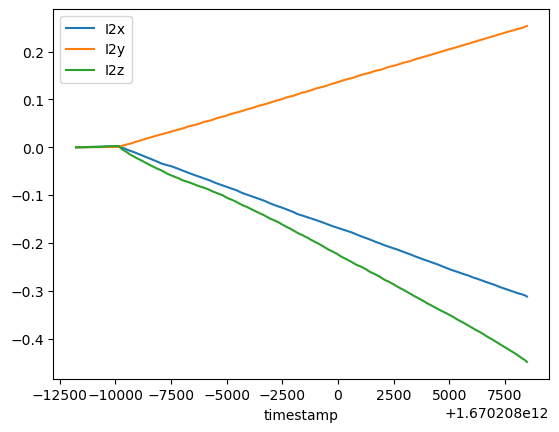

In [11]:
# accel_t.set_index("timestamp").loc[:, ["x", "y", "z"]].plot()
accel_t.set_index("timestamp").loc[:, ["I2x", "I2y", "I2z"]].plot()
# axis = "z"
# accel_t.iloc[1000:].set_index("timestamp").loc[:, [f"I{axis}", f"I2{axis}"]].plot()

In [13]:
# t = accel_t.I2x.values, accel_t.I2y.sum(), accel_t.I2z.sum()
t = accel_t.values[-1, -3:]

In [9]:
# gyro_t = gyro_df[(accel_df.timestamp >= start_t) & (accel_df.timestamp <= end_t)]
gyro_t = gyro_df.copy()
# remove redundant data
gyro_t = gyro_t.drop_duplicates("timestamp")
# calculating time difference
# gyro_t.loc[:, "dt"] = np.concatenate([[0], (gyro_t.timestamp.values[1:] - gyro_t.timestamp.values[:-1]) / 1000])
gyro_t.loc[:, "dt"] = (gyro_t.timestamp.values - gyro_t.timestamp.values[0]) / 1000
# remove first row
gyro_t = gyro_t.iloc[1:]

In [12]:
gyro_t

,timestamp,x,y,z,dt,Ix,Iy,Iz
1,1.670208e+12,0.022678,-0.017455,3.489676e-03,0.001,0.000000,0.000000,0.000000e+00
6,1.670208e+12,0.020933,-0.010474,1.744347e-03,0.002,0.000022,-0.000014,2.617011e-06
11,1.670208e+12,0.020933,-0.010474,-9.826368e-07,0.003,0.000043,-0.000024,3.488693e-06
16,1.670208e+12,0.022678,-0.010474,-1.746312e-03,0.004,0.000065,-0.000035,2.615046e-06
19,1.670208e+12,0.022678,-0.010474,-1.746312e-03,0.005,0.000087,-0.000045,8.687341e-07
...,...,...,...,...,...,...,...,...
11637,1.670208e+12,-0.129166,0.137879,-3.839823e-02,19.617,0.012837,2.194322,4.363418e-01
11639,1.670208e+12,-0.122184,0.127407,-3.839823e-02,19.619,0.012586,2.194588,4.362650e-01
11640,1.670208e+12,-0.122184,0.127407,-3.839823e-02,19.622,0.012219,2.194970,4.361498e-01
11642,1.670208e+12,-0.144874,0.106463,-4.363421e-02,19.624,0.011952,2.195204,4.360678e-01


In [10]:
gyro_t.loc[:, "Ix"] = scipy.integrate.cumtrapz(gyro_t.x.values, gyro_t.dt.values, initial=0)
gyro_t.loc[:, "Iy"] = scipy.integrate.cumtrapz(gyro_t.y.values, gyro_t.dt.values, initial=0)
gyro_t.loc[:, "Iz"] = scipy.integrate.cumtrapz(gyro_t.z.values, gyro_t.dt.values, initial=0)

<AxesSubplot:xlabel='timestamp'>

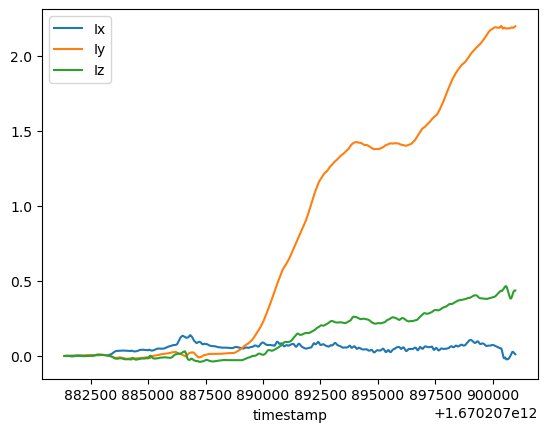

In [11]:
gyro_t.set_index("timestamp").loc[:, ["Ix", "Iy", "Iz"]].plot()

In [16]:
# R = gyro_t.Ix.sum(), gyro_t.Iy.sum(), gyro_t.Iz.sum()
R = gyro_t.values[-1, -3:]

In [17]:
T = helpers.rotate_transformation_matrix(np.identity(4), R[0], R[1], R[2])
T[:3, 3] = t

In [18]:
print(f"Translation: {t}", end="\t")
print(f"Rotation: {R}")

Translation: [ 1.37061981 -0.52655336 -0.50749188]	Rotation: [0.01151751 2.19552323 0.4359369 ]


In [78]:
source = camera.depth_to_point_cloud(os.path.join(sequence_dir, f"frame-{start_t}.depth.png"))
target = camera.depth_to_point_cloud(os.path.join(sequence_dir, f"frame-{end_t}.depth.png"))

In [79]:
registration.view(source, target, T)

In [23]:
accel_df = accel_df.drop_duplicates("timestamp")

In [24]:
samples = accel_df.shape[0]
duration = accel_df.timestamp.values[-1] - accel_df.timestamp.values[0]

In [26]:
samples / duration * 1000

401.9453652399042

Experiment to check integration with simulated data

In [40]:
imu = [[2] for _ in range(2000)] + [[0] for _ in range(3000)] + [[-2] for _ in range(2000)]
timestamps = [[i] for i in range(7000)]

data = np.concatenate([timestamps, imu], axis=1)

accel_df = pd.DataFrame(data, columns=["timestamp", "x"])

In [42]:
accel_df.loc[:, "dt"] = (accel_df.timestamp.values - accel_df.timestamp.values[0]) / 1000
# remove first row
accel_df = accel_df.iloc[1:]

In [43]:
accel_df.loc[:, "Ix"] = scipy.integrate.cumtrapz(accel_df.x.values, accel_df.dt.values, initial=0)

In [48]:
accel_df.loc[:, "I2x"] = scipy.integrate.cumtrapz(accel_df.Ix.values, accel_df.dt.values, initial=0)

<AxesSubplot:xlabel='timestamp'>

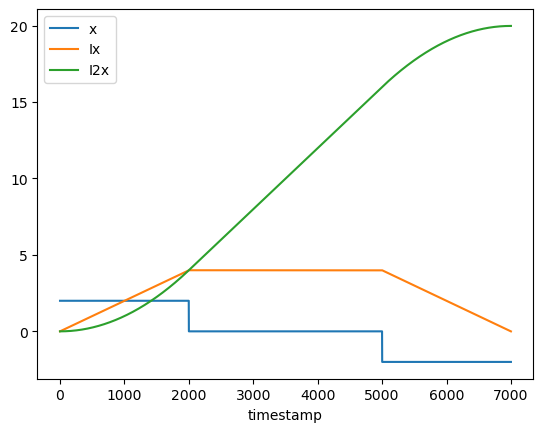

In [49]:
accel_df.set_index("timestamp").loc[:, ["x", "Ix", "I2x"]].plot()

In [52]:
d = 0.5 * 2 * 4 + 4 * 3 + 0.5 * 4 * 2
print(f"Total distance: {d}")

Total distance: 20.0


Linear acceleration from Android API

In [84]:
accel_t = pd.read_csv("data/android/1672368068866/acceleration.csv", names=["timestamp", "x", "y", "z"])

In [85]:
accel_t = accel_t.drop_duplicates("timestamp")
accel_t = accel_t.iloc[500:]
# calculating time difference
accel_t.loc[:, "dt"] = np.concatenate([[0], (accel_t.timestamp.values[1:] - accel_t.timestamp.values[:-1]) / 1000])
# accel_t.loc[:, "dt"] = (accel_t.timestamp.values - accel_t.timestamp.values[0]) / 1000
# remove first row
accel_t = accel_t.iloc[1:]

In [86]:
accel_t.loc[:, "Ix"] = scipy.integrate.cumtrapz(accel_t.x.values, accel_t.dt.values, initial=0)
accel_t.loc[:, "Iy"] = scipy.integrate.cumtrapz(accel_t.y.values, accel_t.dt.values, initial=0)
accel_t.loc[:, "Iz"] = scipy.integrate.cumtrapz(accel_t.z.values, accel_t.dt.values, initial=0)

accel_t.loc[:, "I2x"] = scipy.integrate.cumtrapz(accel_t.Ix.values, accel_t.dt.values, initial=0)
accel_t.loc[:, "I2y"] = scipy.integrate.cumtrapz(accel_t.Iy.values, accel_t.dt.values, initial=0)
accel_t.loc[:, "I2z"] = scipy.integrate.cumtrapz(accel_t.Iz.values, accel_t.dt.values, initial=0)

In [87]:
displacement = [0, 0, 0]
velocity = [0, 0, 0]

for i in range(len(accel_t)):
    imu = accel_t.iloc[i].values
    for j, axis in enumerate(["x", "y", "z"]):
        velocity[j] = velocity[j] + imu[j + 1] * imu[4] # 4 = dt
        # Update the displacement
        displacement[j] = displacement[j] + (velocity[j] * imu[4]) + (0.5 * imu[j + 1] * imu[4] * imu[4])

        accel_t.iloc[i, 5 + j] = velocity[j]
        accel_t.iloc[i, 8 + j] = displacement[j]

<AxesSubplot:xlabel='timestamp'>

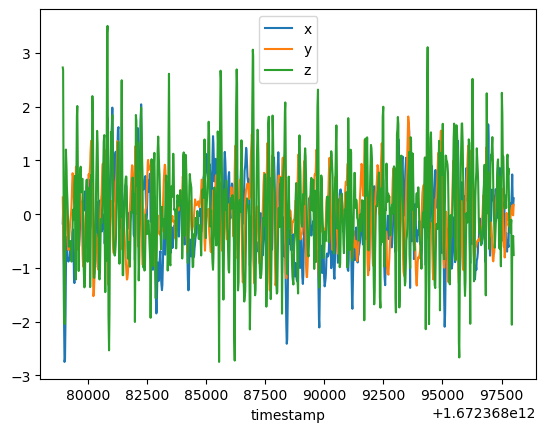

In [88]:
accel_t.set_index("timestamp").loc[:, ["x", "y", "z"]].plot()

<AxesSubplot:xlabel='timestamp'>

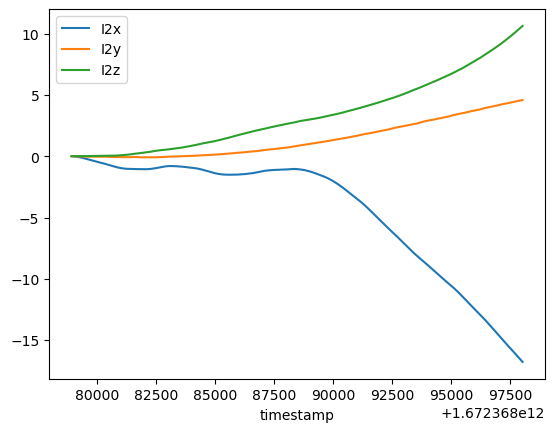

In [89]:
accel_t.set_index("timestamp").loc[:, ["I2x", "I2y", "I2z"]].plot()

In [90]:
xyz = accel_t.loc[:, ["I2x", "I2y", "I2z"]].values

In [91]:
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(xyz)

In [92]:
open3d.visualization.draw_geometries([pcd])

In [11]:
gyro_t = pd.read_csv("data/android/1672368005956/gyroscope.csv", names=["timestamp", "x", "y", "z"])

In [14]:
gyro_t = gyro_t.drop_duplicates("timestamp")
# calculating time difference
# gyro_t.loc[:, "dt"] = np.concatenate([[0], (gyro_t.timestamp.values[1:] - gyro_t.timestamp.values[:-1]) / 1000])
gyro_t.loc[:, "dt"] = (gyro_t.timestamp.values - gyro_t.timestamp.values[0]) / 1000
# remove first row
gyro_t = gyro_t.iloc[1:]

In [15]:
gyro_t.loc[:, "Ix"] = scipy.integrate.cumtrapz(gyro_t.x.values, gyro_t.dt.values, initial=0)
gyro_t.loc[:, "Iy"] = scipy.integrate.cumtrapz(gyro_t.y.values, gyro_t.dt.values, initial=0)
gyro_t.loc[:, "Iz"] = scipy.integrate.cumtrapz(gyro_t.z.values, gyro_t.dt.values, initial=0)

<AxesSubplot:xlabel='timestamp'>

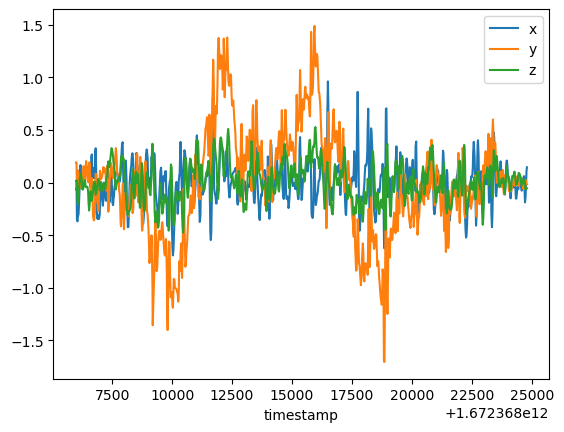

In [13]:
gyro_t.set_index("timestamp").loc[:, ["x", "y", "z"]].plot()

<AxesSubplot:xlabel='timestamp'>

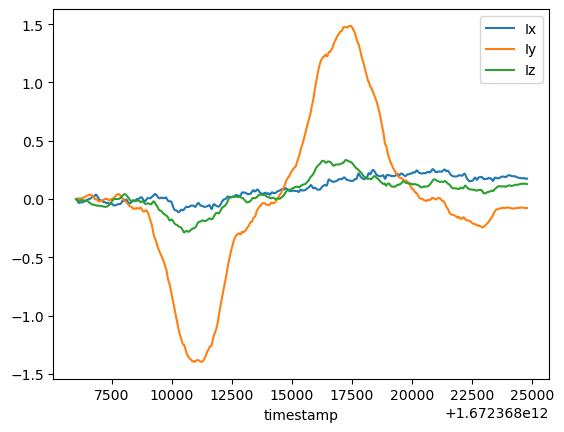

In [16]:
gyro_t.set_index("timestamp").loc[:, ["Ix", "Iy", "Iz"]].plot()

In [33]:
accel_t.loc[:, "gyro_t"] = accel_t.apply(lambda x: nearest(gyro_t.timestamp.values, x.timestamp), axis=1)

In [39]:
trajectory_t = pd.merge(
    accel_t.loc[:, ["gyro_t", "I2x", "I2y", "I2z"]],
    gyro_t.loc[:, ["timestamp", "Ix", "Iy", "Iz"]],
    left_on="gyro_t",
    right_on="timestamp"
)

In [50]:
xyz = []

for i in range(len(trajectory_t)):
    data = trajectory_t.iloc[i]
    R = helpers.rotate_transformation_matrix(np.identity(4), data.Ix, data.Iy, data.Iz)
    x = np.array([data.I2x, data.I2y, data.I2z, 1])

    p = np.dot(R, x)
    xyz.append(p[:3].tolist())

xyz = np.array(xyz)

In [51]:
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(xyz)

In [52]:
open3d.visualization.draw_geometries([pcd])